# 데이터 로드
-----

In [1]:
import requests
import pandas as pd
import json
import re
import ast

# 1. API 테스트
## 1.1. 닉네임으로 계정 정보 불러오기

In [11]:
# API 연결
api_key = 'RGAPI-8e911f79-5a62-43e3-a478-a2704b69f3fe'
id_url = "https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/" + "hide on bush" +'?api_key=' + api_key
r = requests.get(id_url)
id_url

'https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/hide on bush?api_key=RGAPI-8e911f79-5a62-43e3-a478-a2704b69f3fe'

In [12]:
# 연결 확인 response 200이 떠야함
r

<Response [200]>

In [13]:
r.json()

{'id': 'lIHYffhW1aGsW2LNkHw6u4pbzCOi0IJPpn8Wv5bg-OwpEA',
 'accountId': 'rVddqy5Yw7hPt6vg9HWiiHBXUzwXtwX1oHs2aF4tVv8y',
 'puuid': '8tNnupjZE2-8Bgg6NHLTy0h6cxu0GtjT0aHhwQXZv-OyYq-Il54A4v9by90bYeniDMWmqRMBxn2Ndw',
 'name': 'Hide on bush',
 'profileIconId': 6,
 'revisionDate': 1586346271000,
 'summonerLevel': 302}

## 1.2. 계정정보의 id 데이터로 게임 정보 불러오기

In [14]:
tier_url = "https://kr.api.riotgames.com/lol/league/v4/entries/by-summoner/" + r.json()['id'] +'?api_key=' + api_key
r = requests.get(tier_url)
r.json()

[{'leagueId': '461c35cf-13a7-3e52-b83b-ae9721ed77c8',
  'queueType': 'RANKED_SOLO_5x5',
  'tier': 'GRANDMASTER',
  'rank': 'I',
  'summonerId': 'lIHYffhW1aGsW2LNkHw6u4pbzCOi0IJPpn8Wv5bg-OwpEA',
  'summonerName': 'Hide on bush',
  'leaguePoints': 457,
  'wins': 176,
  'losses': 163,
  'veteran': True,
  'inactive': False,
  'freshBlood': False,
  'hotStreak': False}]

# 2. 데이터 수집

## 2.1. 그랜드마스터 정보 불러오기

In [15]:
grandmaster = 'https://kr.api.riotgames.com/lol/league/v4/grandmasterleagues/by-queue/RANKED_SOLO_5x5?api_key=' + api_key
r = requests.get(grandmaster)
league_df = pd.DataFrame(r.json())

league_df.reset_index(inplace=True) # 수집한 그마데이터 index정리
league_entries_df = pd.DataFrame(dict(league_df['entries'])).T # dict구조로 되어 있는 entries컬럼 풀어주기
league_df = pd.concat([league_df, league_entries_df], axis=1) # 열끼리 결합

league_df = league_df.drop(['index', 'queue', 'name', 'leagueId', 'entries', 'rank'], axis=1)
league_df.info()
# league_df.to_csv('C:/Users/kjh96/Github/Study_LOL/grandmaster700.csv',index=False,encoding = 'cp949') 중간 저장 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tier          700 non-null    object
 1   summonerId    700 non-null    object
 2   summonerName  700 non-null    object
 3   leaguePoints  700 non-null    object
 4   wins          700 non-null    object
 5   losses        700 non-null    object
 6   veteran       700 non-null    object
 7   inactive      700 non-null    object
 8   freshBlood    700 non-null    object
 9   hotStreak     700 non-null    object
dtypes: object(10)
memory usage: 54.8+ KB


In [16]:
# 그랜드마스터 정보
league_df.head()

,tier,summonerId,summonerName,leaguePoints,wins,losses,veteran,inactive,freshBlood,hotStreak
0,GRANDMASTER,GlU_EU46xaZ2BBOoJBf4zZs9yGFSDg0ifZpgwMSBrNtONbA,Gen G Ophelia,447,443,424,False,False,True,False
1,GRANDMASTER,josWQ2gYr8hFZCcL924J_SIVGp0PzyKuoI029n8_-JEMMco,kamoufIage,391,246,226,False,False,True,False
2,GRANDMASTER,oJooJALkiVa9rOD7lIK63ra4sTs2krVM1QwBOGHJIOWl0mE,mangseorijima,320,226,147,False,False,True,False
3,GRANDMASTER,YcQdYK6gpWeHablQ9O0WA4O9sOK4XFu-p7WgtixMK5-gwg,KT Kyuhyunji,422,88,60,False,False,False,False
4,GRANDMASTER,2I3rSKNEEH75EktTivg435efKgKXEn7SFiKxuBGGExhWe_U,teamuoon,129,317,298,False,False,True,False


In [17]:
league_df.shape

(700, 10)

## 2.2. 그랜드마스터 정보 고유 ID 추가

In [18]:
league_df['accountId'] = ""
for i in range(len(league_df)):
    try:
        sohwan = 'https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/' + league_df['summonerName'].iloc[i] + '?api_key=' + api_key 
        r = requests.get(sohwan)
        
        while r.status_code == 429:
            time.sleep(5)
            sohwan = 'https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/' + league_df['summonerName'].iloc[i] + '?api_key=' + api_key 
            r = requests.get(sohwan)
            
        account_id = r.json()['accountId']
        league_df['accountId'][i] = account_id #league_df.iloc[i, -1] = account_id
    
    except:
        pass

In [19]:
league_df.head()

,tier,summonerId,summonerName,leaguePoints,wins,losses,veteran,inactive,freshBlood,hotStreak,accountId
0,GRANDMASTER,GlU_EU46xaZ2BBOoJBf4zZs9yGFSDg0ifZpgwMSBrNtONbA,Gen G Ophelia,447,443,424,False,False,True,False,HtTA2PR1xHv5GM8E2Bw4CIntMP-VsIytJhsCvgx_sGcoGOc
1,GRANDMASTER,josWQ2gYr8hFZCcL924J_SIVGp0PzyKuoI029n8_-JEMMco,kamoufIage,391,246,226,False,False,True,False,LZVSHQnp4y0cjOhNuNw45QC3y5EYDU2yoyyPR0RrFDhNVrM
2,GRANDMASTER,oJooJALkiVa9rOD7lIK63ra4sTs2krVM1QwBOGHJIOWl0mE,mangseorijima,320,226,147,False,False,True,False,EE6J8kNGVayreTg4gOWAi9q_FAa7Z69i7uZfkm6JoZujEK...
3,GRANDMASTER,YcQdYK6gpWeHablQ9O0WA4O9sOK4XFu-p7WgtixMK5-gwg,KT Kyuhyunji,422,88,60,False,False,False,False,lVXN_sRa6GiDPL95SdLdAvfGrHBzpCwTkpFW2NLQmK_B
4,GRANDMASTER,2I3rSKNEEH75EktTivg435efKgKXEn7SFiKxuBGGExhWe_U,teamuoon,129,317,298,False,False,True,False,0ni3ehjm4PV0-OEpQ5wSvqpCT9SassidZ83fo6Zh7Of-2Kg


In [20]:
league_df['accountId'].value_counts()

                                                            503
uQ7ROHPm_QoTyY9P0g8koqhY-zDLkRWApy17zneIA56bxSs               1
zlyZR0-2mKQXCyaQrX_JN7CyWD-IgRlS9j7BUYagNSDHUMQ               1
v1ed7rOvPcBuaIpBNp9469_4J-CJ8lOmWosJYlPNtyFMtVxe2NwsuPjj      1
epORW_AXliIcAO1RMrtM7Z2zsa2wbN55E4CWIfdSNdN12kA               1
                                                           ... 
THJZbUTv_RHvIKwQ-9DaEkoZtbTvmjvUdtR3qhZo1idBJpjyL5OsbAUX      1
N42cWjFop_N6M_vbaksjlDTLQsTzrRir0tQlETcSQnxpb1JO9TNiuS53      1
aP2_YSOlAATpZEte_uRf_YqoqIzco4o87VnlyZsqueYl7tqMgo3pSXUd      1
QriD3s8vWo3IUg2mh7kMoECIyZilbCZOIJl60QcdgYxpITOY27TMaaMU      1
WoTrx-mbbGdfUeOhY6cfv7jRgoBoVxs6aua6CXYFQsVTQSsOWQ34XlHG      1
Name: accountId, Length: 198, dtype: int64

## 2.3. 고유 ID로 13시즌 데이터 수집하기

In [23]:
# API키 교체
api_key = "RGAPI-0ada5dd7-9485-4196-a512-7be8e702e1e0"

In [27]:
# 연결 확인
r

<Response [429]>

In [21]:
#13시즌의 데이터만을 이용할 것
match_info_df = pd.DataFrame()
season = str(13)
for i in range(len(league_df)):
    try:
        match0 = 'https://kr.api.riotgames.com/lol/match/v4/matchlists/by-account/' + league_df['accountId'].iloc[i]  +'?season=' + season + '&api_key=' + api_key
        r = requests.get(match0)
        
        while r.status_code == 429:
            time.sleep(5)
            match0 = 'https://kr.api.riotgames.com/lol/match/v4/matchlists/by-account/' + league_df['accountId'].iloc[i]  +'?season=' + season + '&api_key=' + api_key
            r = requests.get(match0)
            
        match_info_df = pd.concat([match_info_df, pd.DataFrame(r.json()['matches'])])
    
    except:
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [22]:
match_info_df.head()

,platformId,gameId,champion,queue,season,timestamp,role,lane
0,KR,4286387858,523,450,13,1586410888901,DUO,NONE
1,KR,4285880231,429,420,13,1586369991187,DUO_CARRY,BOTTOM
2,KR,4285795613,429,420,13,1586367198803,DUO_SUPPORT,NONE
3,KR,4285629666,523,420,13,1586364051242,DUO_CARRY,BOTTOM
4,KR,4285654874,235,420,13,1586362449345,NONE,JUNGLE


In [23]:
match_info_df.shape

(10000, 8)

In [24]:
match_info_df.to_csv("C:/Users/kjh96/Github/Study_LOL/match_info_df.csv")

## 2.4. 게임ID로 매치정보 불러오기

In [2]:
api_key = "RGAPI-a63f516c-a1e4-4939-952b-3b5200f605d0"

In [3]:
match_info_df2 = pd.read_csv("C:/Users/kjh96/Github/Study_LOL/match_info_df.csv")

In [4]:
match_info_df2.head()

,platformId,gameId,champion,queue,season,timestamp,role,lane
0,KR,4286387858,523,450,13,1.586410e+12,DUO,NONE
1,KR,4285880231,429,420,13,1.586370e+12,DUO_CARRY,BOTTOM
2,KR,4285795613,429,420,13,1.586370e+12,DUO_SUPPORT,NONE
3,KR,4285629666,523,420,13,1.586360e+12,DUO_CARRY,BOTTOM
4,KR,4285654874,235,420,13,1.586360e+12,NONE,JUNGLE


In [5]:
match_fin = pd.DataFrame()
for i in range(len(match_info_df2)):
    try:           
        api_url='https://kr.api.riotgames.com/lol/match/v4/matches/' + str(match_info_df2['gameId'].iloc[i]) + '?api_key=' + api_key
        r = requests.get(api_url)

        while r.status_code == 429:
            time.sleep(2)
            #time.sleep를 꼭 해줘야함 안그러면 request 잦은 사용으로 블랙리스트가 됨
            api_url='https://kr.api.riotgames.com/lol/match/v4/matches/' + str(match_info_df2['gameId'].iloc[i]) + '?api_key=' + api_key
            r = requests.get(api_url)
        
        mat = pd.DataFrame(list(r.json().values()), index=list(r.json().keys())).T
        match_fin = pd.concat([match_fin,mat])

    except:
        pass
%time

In [6]:
match_fin.head()

,gameId,platformId,gameCreation,gameDuration,queueId,mapId,seasonId,gameVersion,gameMode,gameType,teams,participants,participantIdentities,status
0,4286387858,KR,1586410888901,518,450,12,13,10.7.314.9802,ARAM,MATCHED_GAME,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
0,4285880231,KR,1586369991187,1796,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
0,4285795613,KR,1586367198803,1184,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
0,4285629666,KR,1586364051242,1677,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
0,4285654874,KR,1586362449345,1214,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN


In [7]:
match_fin.to_csv("C:/Users/kjh96/Github/Study_LOL/match_fin.csv")

In [264]:
match_fin.head()

,gameId,platformId,gameCreation,gameDuration,queueId,mapId,seasonId,gameVersion,gameMode,gameType,teams,participants,participantIdentities,status
0,4286387858,KR,1586410888901,518,450,12,13,10.7.314.9802,ARAM,MATCHED_GAME,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
0,4285880231,KR,1586369991187,1796,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
0,4285795613,KR,1586367198803,1184,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
0,4285629666,KR,1586364051242,1677,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
0,4285654874,KR,1586362449345,1214,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN


In [ ]:
# 문자열 리스트형으로 전환
#for i in range(len(match_fin)):
#    match_fin['re_teams'][i] = ast.literal_eval(match_fin['teams'][i].copy())

## 2.5 매치별 정보 취합하기

In [265]:
match_fin.head()

,gameId,platformId,gameCreation,gameDuration,queueId,mapId,seasonId,gameVersion,gameMode,gameType,teams,participants,participantIdentities,status
0,4286387858,KR,1586410888901,518,450,12,13,10.7.314.9802,ARAM,MATCHED_GAME,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
0,4285880231,KR,1586369991187,1796,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
0,4285795613,KR,1586367198803,1184,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
0,4285629666,KR,1586364051242,1677,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
0,4285654874,KR,1586362449345,1214,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN


In [308]:
data = match_fin

In [309]:
data.shape

(2210, 14)

### 2.5.1. 결측치 제거

In [310]:
data.isnull().sum()

gameId                     20
platformId                 20
gameCreation               20
gameDuration               20
queueId                    20
mapId                      20
seasonId                   20
gameVersion                20
gameMode                   20
gameType                   20
teams                      20
participants               20
participantIdentities      20
status                   2190
dtype: int64

In [311]:
data[data['gameId'].isnull() == True]

,gameId,platformId,gameCreation,gameDuration,queueId,mapId,seasonId,gameVersion,gameMode,gameType,teams,participants,participantIdentities,status
message,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gateway timeout
status_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,504
message,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gateway timeout
status_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,504
message,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gateway timeout
status_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,504
message,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gateway timeout
status_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,504
message,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Service unavailable
status_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,503


In [317]:
data = data[data['gameId'].isnull() == False].reset_index().drop(['index'],axis=1)
data.head()

,gameId,platformId,gameCreation,gameDuration,queueId,mapId,seasonId,gameVersion,gameMode,gameType,teams,participants,participantIdentities,status
0,4286387858,KR,1586410888901,518,450,12,13,10.7.314.9802,ARAM,MATCHED_GAME,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
1,4285880231,KR,1586369991187,1796,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
2,4285795613,KR,1586367198803,1184,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
3,4285629666,KR,1586364051242,1677,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN
4,4285654874,KR,1586362449345,1214,420,11,13,10.7.314.9802,CLASSIC,MATCHED_GAME,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ...","[{'participantId': 1, 'teamId': 100, 'champion...","[{'participantId': 1, 'player': {'platformId':...",NaN


In [318]:
data.shape

(2190, 14)

In [319]:
#챔피언아이디를 제외하고 딕셔너리를 뽑는다
a_ls = list(data['teams'])

In [338]:
#team1
team1_df = pd.DataFrame()
for i in range(len(a_ls)):
    try:
        a_ls[i][0].pop('bans',None)
        team1 = pd.DataFrame(list(a_ls[i][0].values()),index = list(a_ls[i][0].keys())).T
        team1_df = team1_df.append(team1)
    except:
        pass
    
team1_df.index = range(len(team1_df))

#team2
team2_df = pd.DataFrame()
error = []
for i in range(len(a_ls)):
    try:
        a_ls[i][1].pop('bans',None)
        team2 = pd.DataFrame(list(a_ls[i][1].values()),index = list(a_ls[i][1].keys())).T
        team2_df = team2_df.append(team2)
    except:
        pass
        
    
team2_df.index = range(len(team2_df))

In [339]:
len(a_ls[0][0])

15

In [340]:
team1_df.shape

(2190, 15)

In [341]:
team2_df.shape

(2190, 15)

In [342]:
team1_df = pd.concat([team1_df,data['gameDuration']],axis=1)
team2_df = pd.concat([team2_df,data['gameDuration']],axis=1)

In [343]:
data_team = pd.concat([team1_df, team2_df])
data_team = data_team.reset_index().drop(['index'],axis=1)
data_team.to_csv('./data_team.csv')

In [346]:
data_team

,teamId,win,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,vilemawKills,riftHeraldKills,dominionVictoryScore,gameDuration
0,100,Fail,False,False,False,False,False,False,0,0,0,0,0,0,0,518
1,100,Win,True,True,True,True,False,True,9,2,1,2,0,1,0,1796
2,100,Win,True,True,False,False,True,False,4,0,0,2,0,0,0,1184
3,100,Win,True,True,True,True,False,True,6,1,1,2,0,1,0,1677
4,100,Fail,False,True,False,False,True,True,3,0,0,1,0,1,0,1214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,200,Fail,True,False,False,False,True,True,2,0,0,1,0,1,0,1497
4376,200,Win,False,True,True,False,False,False,4,2,0,0,0,0,0,1351
4377,200,Win,False,False,False,False,False,False,4,1,0,0,0,0,0,1606
4378,200,Win,True,True,True,False,False,False,4,2,0,0,0,0,0,1289


# 3. 롤 승패 예측하기

## 3.1 데이터 셀렉

In [355]:
# A팀이 이기는 것은 B팀이 지는 것이므로 A팀만의 정보만으로도 승패 예측 가능, 따라서 A팀 데이터만 사용
data_team1 = data_team[data_team['teamId']==100]
data_team1 = data_team1[list(data_team.columns)[2:]] #타겟데이터를 제외한 나머지 데이터 
data_team1.head()

,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,vilemawKills,riftHeraldKills,dominionVictoryScore,gameDuration
0,False,False,False,False,False,False,0,0,0,0,0,0,0,518
1,True,True,True,True,False,True,9,2,1,2,0,1,0,1796
2,True,True,False,False,True,False,4,0,0,2,0,0,0,1184
3,True,True,True,True,False,True,6,1,1,2,0,1,0,1677
4,False,True,False,False,True,True,3,0,0,1,0,1,0,1214


## 3.2. 라벨링

In [360]:
list(data_team1.iloc[:,1])

[False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True

In [361]:
# T/F 값을 가진 변수 인코딩, 인코딩 방법으로는 ONE HOT ENCODING와 Labeling 중 라벨링 선택
from sklearn.preprocessing import LabelEncoder
for i in range(0,6):
    Label = LabelEncoder()
    y = list(data_team1.iloc[:,i])
    y2 = Label.fit_transform(y)
    data_team1.iloc[:,i] = y2

In [381]:
# 승패도 라벨링
dict_winner = {"Win" : 0, "Fail": 1}
data_team[data_team['teamId']==100]['win'].map(dict_winner).tolist()

[1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,


In [382]:
# train과 test로 데이터를 0.75 : 0.25 비율로 나눈다.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_team1, np.array(data_team[data_team['teamId']==100]['win'].map(dict_winner).tolist()), test_size=0.25, stratify=np.array(data_team[data_team['teamId']==100]['win'].map(dict_winner).tolist()), random_state=123456)

## 3.3 랜덤포레스트

In [383]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train) #소환사 코드를 float로 바꿔줘야함

from sklearn.metrics import accuracy_score
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

#oob_score = out of bag score로써 예측이 얼마나 정확한가에 대한 추정치입니다.
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.934
Mean accuracy score: 0.938


## 3.4. Gradient Boosting classifier

In [387]:
from sklearn.ensemble import GradientBoostingClassifier
clf_gbc = GradientBoostingClassifier()
clf_gbc.fit(X_train,y_train)

y_pred = clf_gbc.predict(X_test)

print('테스트 정확도 = ' + str(accuracy_score(y_test,y_pred)))

테스트 정확도 = 0.9416058394160584


## 3.5. Xgboost

In [388]:
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot

#xgb로 학습시키기 위해서는 dtypes이 단순하게 int형식이면 안된다. 따라서 데이터 형식을 float로 변환시켜줘야함
X_train[['towerKills', 'inhibitorKills', 'baronKills', 'dragonKills', 'vilemawKills', 'riftHeraldKills', 'dominionVictoryScore', 'gameDuration']] = X_train[['towerKills', 'inhibitorKills', 'baronKills', 'dragonKills', 'vilemawKills', 'riftHeraldKills', 'dominionVictoryScore', 'gameDuration']].astype('float')

#xgb로 학습시키기 위해서는 dtypes이 단순하게 int형식이면 안된다. 따라서 데이터 형식을 float로 변환시켜줘야함
X_test[['towerKills', 'inhibitorKills', 'baronKills', 'dragonKills', 'vilemawKills', 'riftHeraldKills', 'dominionVictoryScore', 'gameDuration']] = X_test[['towerKills', 'inhibitorKills', 'baronKills', 'dragonKills', 'vilemawKills', 'riftHeraldKills', 'dominionVictoryScore', 'gameDuration']].astype('float')

xgb_model = XGBClassifier()
xgb_model.fit(X_train,y_train)
y_pred = xgb_model.predict(X_test)

print('테스트 정확도 = ' + str(accuracy_score(y_test,y_pred)))#정확도 계산

테스트 정확도 = 0.9434306569343066


C:\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


## 3.6. 변수 중요도 확인

In [526]:
#한글 폰트 사용
from matplotlib import font_manager,rc
import matplotlib
import matplotlib.pyplot as plt

#폰트 경로
font_path = "C:/Windows/Fonts/H2GTRM.TTF"

#폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()

#font 설정
matplotlib.rc('font',family=font_name)

In [527]:
def plot_feature_importance(model) :
    n_features = data_team1.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("특성중요도")
    plt.ylabel("특성")
    plt.ylim(-1, n_features)

In [528]:
rf.feature_importances_

array([0.01634231, 0.07106496, 0.11999917, 0.03244777, 0.01783937,
       0.01470384, 0.21993054, 0.15462636, 0.02890513, 0.07363284,
       0.        , 0.02201401, 0.        , 0.2284937 ])

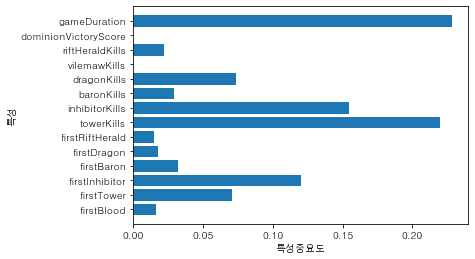

In [529]:
plot_feature_importance(rf)

In [520]:
clf_gbc.feature_importances_

array([1.43842429e-03, 2.07998579e-02, 9.11668684e-04, 5.17767966e-03,
       4.08779941e-04, 3.92512423e-04, 6.01536949e-01, 7.00665007e-02,
       1.09081694e-02, 1.77821951e-02, 0.00000000e+00, 6.59046385e-04,
       0.00000000e+00, 2.69918217e-01])

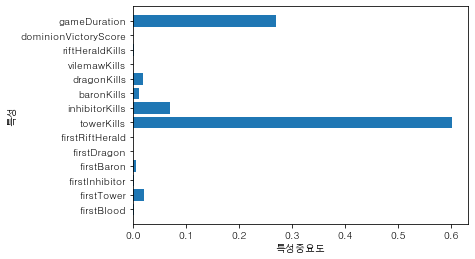

In [530]:
plot_feature_importance(clf_gbc)

In [448]:
xgb_model.feature_importances_

array([0.02159689, 0.0724958 , 0.02111187, 0.0456843 , 0.02069152,
       0.02438454, 0.46338302, 0.16444106, 0.03679619, 0.04440061,
       0.        , 0.02244919, 0.        , 0.06256497], dtype=float32)

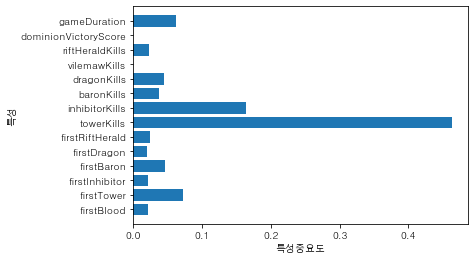

In [531]:
plot_feature_importance(xgb_model)

# 출처
---
https://shinminyong.tistory.com/11?category=839096